# Detect and recognize license plates in Hong Kong using Amazon Rekognition & PaddleOCR

The sample notebook provides comparisons across different methods of getting results of OCR from photos capturing both vehicles and the respective license plates:

1. Raw images processed with Amazon Rekognition [detect_text](https://docs.aws.amazon.com/rekognition/latest/dg/text-detection.html) feature
2. Cropped vehicle (and license) images by Amazon Rekognition [detect_labels](https://docs.aws.amazon.com/rekognition/latest/dg/labels.html) feature, then processed with Amazon Rekognition detect_text feature
3. Cropped license images by Amazon Rekognition [Custom Labels](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/what-is.html) feature, then processed with Amazon Rekognition detect_text feature
4. Cropped license images by Amazon Rekognition Custom Label feature, then processed with [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR)

Images being used in this sample notebook were results searched from [Google](https://www.google.com/search?q=hk%20license%20plate&tbm=isch&tbs=il:ol&hl=zh-TW&sa=X&ved=0CAAQ1vwEahcKEwig9Nq4wZ_3AhUAAAAAHQAAAAAQAg&biw=1425&bih=775) and filtered with "Usage rights" as "Commercial & other licenses".

## 1. Raw images processed with Amazon Rekognition detect_text feature

First, we're going to try using the detect_text feature from Amazon Rekognition to get text values from the supplied images in its raw state. One challenge that will be observed when deploying such use case in production is that, there will be a lot of noise (decorations or text on the vehicles, or street signs nearby) that may affect the results of OCR. It would require huge effort for data processing afterwards.

Detected text for testing/029.jpg:


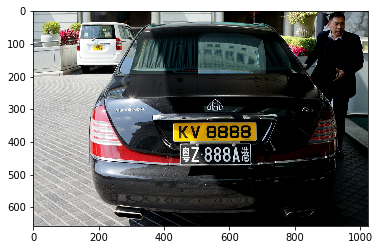

- | Confidence score: 23.273035049438477
AND | Confidence score: 20.71304702758789
7333 MB | Confidence score: 95.72329711914062
MAYBACH | Confidence score: 97.6474380493164
KV 8888 | Confidence score: 99.98351287841797
#Z-888A | Confidence score: 33.06890869140625
- | Confidence score: 23.273035049438477
AND | Confidence score: 20.71304702758789
7333 | Confidence score: 96.24730682373047
MB | Confidence score: 95.19927978515625
MAYBACH | Confidence score: 97.6474380493164
KV | Confidence score: 100.0
8888 | Confidence score: 99.9670181274414
#Z-888A | Confidence score: 33.06890869140625

Detected text for testing/030.jpg:


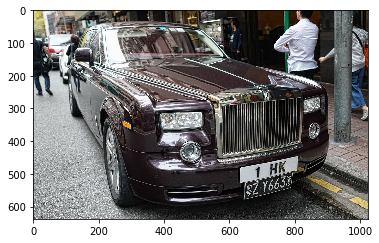

FR | Confidence score: 52.76244354248047
1 HK | Confidence score: 94.3636245727539
UNBA Z Y663 | Confidence score: 68.13069152832031
FR | Confidence score: 52.76244354248047
1 | Confidence score: 98.03611755371094
HK | Confidence score: 90.69113159179688
UNBA | Confidence score: 11.924113273620605
Z | Confidence score: 95.13572692871094
Y663 | Confidence score: 97.33222961425781

Detected text for testing/031.jpg:


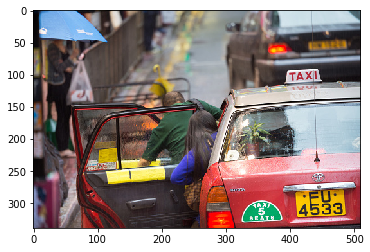

TAXI | Confidence score: 99.47124481201172
TOYOTA | Confidence score: 94.84990692138672
FU | Confidence score: 99.27995300292969
TAXI | Confidence score: 98.55655670166016
5 | Confidence score: 99.12308502197266
4533 | Confidence score: 99.67115020751953
SEATS | Confidence score: 98.16625213623047
TAXI | Confidence score: 99.47124481201172
TOYOTA | Confidence score: 94.84990692138672
FU | Confidence score: 99.27995300292969
TAXI | Confidence score: 98.55655670166016
5 | Confidence score: 99.12308502197266
4533 | Confidence score: 99.67115020751953
SEATS | Confidence score: 98.16625213623047

Detected text for testing/032.jpg:


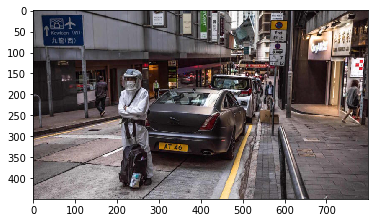

erCourt | Confidence score: 96.39925384521484
MILANO | Confidence score: 22.332658767700195
.... | Confidence score: 84.9699935913086
..... | Confidence score: 81.90663146972656
PRES | Confidence score: 10.991738319396973
- | Confidence score: 88.34330749511719
W | Confidence score: 38.33685302734375
RE | Confidence score: 10.851813316345215
Kowloon (W) | Confidence score: 98.074951171875
End | Confidence score: 98.77184295654297
un | Confidence score: 64.3154525756836
BANK | Confidence score: 9.719267845153809
OrgARde! | Confidence score: 16.53949737548828
LEE BRO LO | Confidence score: 26.672903060913086
١٠ | Confidence score: 24.847713470458984
7 | Confidence score: 98.102783203125
- | Confidence score: 48.70408630371094
1 C | Confidence score: 9.210772514343262
12 | Confidence score: 98.92233276367188
ITILE | Confidence score: 10.260580062866211
DAN | Confidence score: 10.245261192321777
AT 46 | Confidence score: 98.9963150024414
erCourt | Confidence score: 96.39925384521484
MILANO

In [1]:
import boto3
import io
import os
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Optionally, change the region name below to your preferred AWS region
regionName='ap-southeast-1'

s3 = boto3.client('s3', region_name=regionName)
s3_resource = boto3.resource('s3', region_name=regionName)
rekognition=boto3.client('rekognition', region_name=regionName)

# The S3 bucket where you stored the images
bucket = 'your-bucket-name'

# Loop over the objects inside the S3 bucket
for key in s3.list_objects(Bucket=bucket)['Contents']:
    if not key['Key'].endswith('/'):
        if key['Key'].startswith('testing'):
            image_data = s3_resource.Object(bucket,key['Key']).get()['Body'].read()
            image = Image.open(io.BytesIO(image_data))
            imgWidth, imgHeight = image.size
            # Detect labels of objects in the photo with Amazon Rekognition
            text_detections=rekognition.detect_text(Image={'S3Object':{'Bucket': bucket,'Name': key['Key']}})
            print('Detected text for ' + key['Key'] + ':')
            imgplot = plt.imshow(image)
            plt.show()
            for detected_text in text_detections['TextDetections']:
                print(detected_text['DetectedText'] + ' | Confidence score: ' + str(detected_text['Confidence']))
            print()

## 2. Cropped vehicle (and license) images by Amazon Rekognition detect_labels feature, then processed with Amazon Rekognition detect_text feature

Since one of the supported labels that can be detected by using detect_labels from Amazon Rekognition is "Vehicle", we can try to use this feature to crop the images to include just the vehicles (or the license plates) inside the frame. Afterwards, using detect_text to get the text from the images shall be closer to what we want to achieve with less noise.

In [2]:
# Create a local directory for cropped images
directory = 'cropped-images/testing'

if not os.path.exists(directory):
    os.mkdir(directory.split('/')[0])
    os.mkdir(directory)

# Loop over the objects inside the S3 bucket    
for key in s3.list_objects(Bucket=bucket)['Contents']:
    if not key['Key'].endswith('/'):
        if key['Key'].startswith('testing'):
            image_data = s3_resource.Object(bucket,key['Key']).get()['Body'].read()
            image = Image.open(io.BytesIO(image_data))
            imgWidth, imgHeight = image.size
            # Detect labels of objects in the photo with Amazon Rekognition
            labels_detections=rekognition.detect_labels(Image={'S3Object':{'Bucket': bucket,'Name': key['Key']}})
            for index, label in enumerate(labels_detections['Labels']):
                # Crop only the portion of the photo that is labelled as "Vehicle"
                if len(label['Parents']) > 0 and label['Parents'][0]['Name'] == 'Vehicle':
                    if len(label['Instances']) > 0:
                        box = label['Instances'][0]['BoundingBox']
                        left = imgWidth * box['Left']
                        top = imgHeight * box['Top']
                        width = imgWidth * box['Width']
                        height = imgHeight * box['Height']
                        cropped_image_portion = image.crop((left, top, left + width, top + height))
                        cropped_image_key = 'cropped-images/' + key['Key'].split('.')[0] + '-' + str(index) + '.' + key['Key'].split('.')[1]
                        cropped_image_portion.save(cropped_image_key)

cropped-images/testing/029-0.jpg


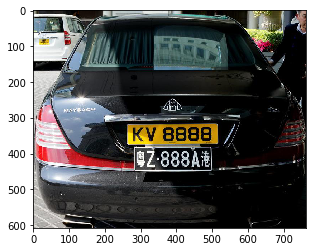

Detected text:
à | Confidence score: 65.5556411743164
MB | Confidence score: 94.12810516357422
7333 | Confidence score: 96.19384002685547
MAYBACH | Confidence score: 98.00735473632812
KV 8888 | Confidence score: 99.95108795166016
ZZ-888A | Confidence score: 20.01837730407715
à | Confidence score: 65.5556411743164
MB | Confidence score: 94.12810516357422
7333 | Confidence score: 96.19384002685547
MAYBACH | Confidence score: 98.00735473632812
KV | Confidence score: 100.0
8888 | Confidence score: 99.90217590332031
ZZ-888A | Confidence score: 20.01837730407715

cropped-images/testing/029-6.jpg


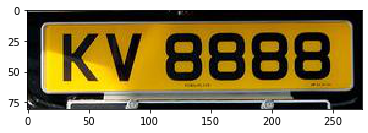

Detected text:
KV 8888 - | Confidence score: 72.05229187011719
- | Confidence score: 39.045509338378906
KV | Confidence score: 100.0
8888 | Confidence score: 99.82672119140625
- | Confidence score: 16.330129623413086
- | Confidence score: 39.045509338378906

cropped-images/testing/030-2.jpg


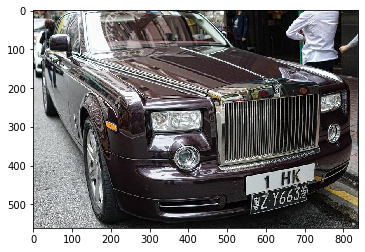

Detected text:
RB | Confidence score: 21.774967193603516
1 HK | Confidence score: 96.01949310302734
0Z Y663 | Confidence score: 16.728668212890625
RB | Confidence score: 21.774967193603516
1 | Confidence score: 98.01001739501953
HK | Confidence score: 94.02897644042969
0Z Y663 | Confidence score: 16.728668212890625

cropped-images/testing/031-2.jpg


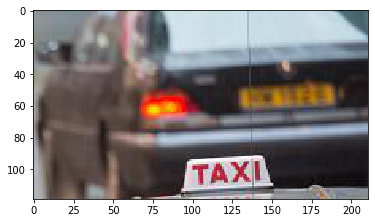

Detected text:
TAXI | Confidence score: 99.38423919677734
TAXI | Confidence score: 99.38423919677734

cropped-images/testing/031-8.jpg


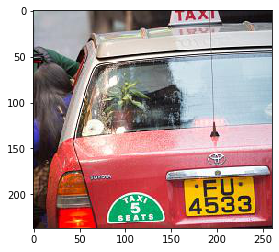

Detected text:
TAXI | Confidence score: 95.47708892822266
TOYOTA | Confidence score: 96.75395965576172
FU | Confidence score: 99.47498321533203
TAXI | Confidence score: 98.75621795654297
5 | Confidence score: 99.43914031982422
4533 | Confidence score: 99.63037872314453
SEATS | Confidence score: 98.23776245117188
TAXI | Confidence score: 95.47708892822266
TOYOTA | Confidence score: 96.75395965576172
FU | Confidence score: 99.47498321533203
TAXI | Confidence score: 98.75621795654297
5 | Confidence score: 99.43914031982422
4533 | Confidence score: 99.63037872314453
SEATS | Confidence score: 98.23776245117188

cropped-images/testing/032-2.jpg


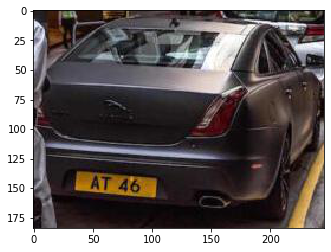

Detected text:
AT 46 | Confidence score: 99.18661499023438
AT | Confidence score: 99.17691802978516
46 | Confidence score: 99.19630432128906



In [3]:
file_list = sorted(os.listdir(directory))

for file in file_list:
    if not file.endswith('.ipynb_checkpoints'):
        print(directory + '/' + file)
        img = mpimg.imread(directory + '/' + file)
        imgplot = plt.imshow(img)
        plt.show()
        file_path = directory + '/' + file
        with open(file_path, 'rb') as image:
            # Detect text on the cropped photos with Amazon Rekognition
            text_detection = rekognition.detect_text(Image={'Bytes': image.read()})
            print('Detected text:')
            for detected_text in text_detection['TextDetections']:
                print(detected_text['DetectedText'] + ' | Confidence score: ' + str(detected_text['Confidence']))
            print()

## 3. Cropped license images by Amazon Rekognition Custom Labels feature, then processed with Amazon Rekognition detect_text feature

In some cases as observed above, however, would still produce quite an amount of unrelated text values mostly from the printing on the vehicles' surafce. We may want to further ensure the images processed by our OCR solution here include only the license plate portion to minimize the noise. While the generic detect_labels feature is not customizable, Amazon Rekognition provides another feature called Custom Labels. You can actually train an object detection model with your own supplied images and labels. So that the object detection model trained would be tailor-made for your use case to provide a better detection result.

For details of how to train a model with Amazon Rekognition Custom Labels, you may refer to the documentation [here](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/getting-started.html)

Here is an example of labeled dataset in Amazon Rekognition Custom Labels:
![Dataset](assets/AmazonRekognitionCustomLabels_Dataset.png)

And here is the sample test results after a model had been trained:
![TestResults](assets/AmazonRekognitionCustomLabels_ModelTest.png)

Once your model is ready, you can get the model resource ARN from the project you created:
![ModelARN](assets/AmazonRekognitionCustomLabels_ModelARN.png)

Then you can implement the sample code block below for the license plate cropping, followed by Amazon Rekognition detect_text again. This time all OCR results shall be focusing on the license plate only.

In [4]:
# Replace below with your trained Custom Labels model resource ARN
custom_label_model='your-model-arn'
min_confidence=80

# Create another local directory to store images there are cropped to include only the license plate portions
directory = 'cropped-images/licenses'

if not os.path.exists(directory):
    os.mkdir(directory)

# Loop over the objects inside the S3 bucket
for key in s3.list_objects(Bucket=bucket)['Contents']:
    if not key['Key'].endswith('/'):
        if key['Key'].startswith('testing'):
            image_data = s3_resource.Object(bucket,key['Key']).get()['Body'].read()
            image = Image.open(io.BytesIO(image_data))
            imgWidth, imgHeight = image.size
            # Detect labels of objects in the photo with Amazon Rekognition
            lp_detection = rekognition.detect_custom_labels(Image={'S3Object':{'Bucket': bucket,'Name': key['Key']}},
                    MinConfidence=min_confidence,
                    ProjectVersionArn=custom_label_model)
            draw = ImageDraw.Draw(image)

            for index, customLabel in enumerate(lp_detection['CustomLabels']):
    
                if 'Geometry' in customLabel:
                    box = customLabel['Geometry']['BoundingBox']
                    left = imgWidth * box['Left']
                    top = imgHeight * box['Top']
                    width = imgWidth * box['Width']
                    height = imgHeight * box['Height']
        
                    license_plate_portion = image.crop((left, top, left + width, top + height))
                    lp_image_key = 'cropped-images/licenses/' + key['Key'].split('/')[1].split('.')[0] + '-' + str(index) + '.' + key['Key'].split('.')[1]
                    license_plate_portion.save(lp_image_key)

cropped-images/licenses/029-0.jpg


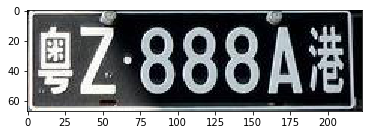

Detected text:
Z-888A | Confidence score: 38.12606430053711
Z-888A | Confidence score: 38.12606430053711

cropped-images/licenses/029-1.jpg


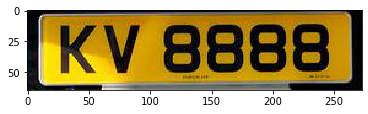

Detected text:
KV 8888 | Confidence score: 99.9099349975586
HANKIN | Confidence score: 11.715972900390625
KV | Confidence score: 100.0
8888 | Confidence score: 99.81987762451172
HANKIN | Confidence score: 11.715972900390625

cropped-images/licenses/029-2.jpg


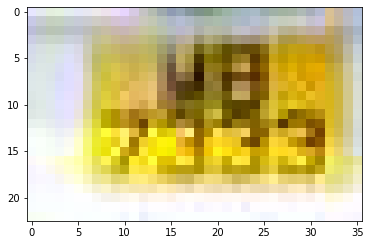

Detected text:
V8 | Confidence score: 29.010421752929688
7333 | Confidence score: 98.32197570800781
V8 | Confidence score: 29.010421752929688
7333 | Confidence score: 98.32197570800781

cropped-images/licenses/030-0.jpg


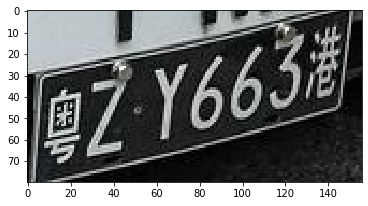

Detected text:
QZY663 | Confidence score: 31.264686584472656
QZY663 | Confidence score: 31.264686584472656

cropped-images/licenses/030-1.jpg


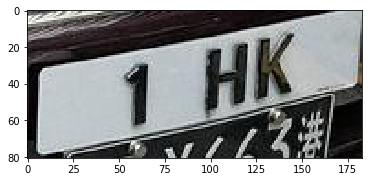

Detected text:
1 HK | Confidence score: 95.07284545898438
1 | Confidence score: 97.10023498535156
HK | Confidence score: 93.04545593261719

cropped-images/licenses/031-0.jpg


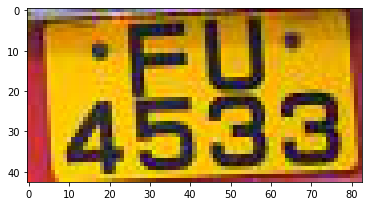

Detected text:
FU | Confidence score: 99.24946594238281
4533 | Confidence score: 99.60133361816406
FU | Confidence score: 99.24946594238281
4533 | Confidence score: 99.60133361816406

cropped-images/licenses/031-1.jpg


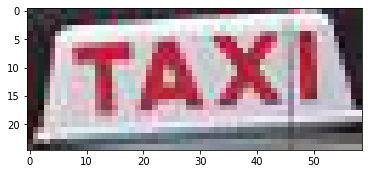

Detected text:
TAXI | Confidence score: 99.36810302734375
TAXI | Confidence score: 99.36810302734375



In [5]:
file_list = sorted(os.listdir(directory))

for file in file_list:
    if not file.endswith('.ipynb_checkpoints'):
        print(directory + '/' + file)
        img = mpimg.imread(directory + '/' + file)
        imgplot = plt.imshow(img)
        plt.show()
        file_path = directory + '/' + file
        with open(file_path, 'rb') as image:
            # Detect text on the cropped photos with Amazon Rekognition
            text_detection = rekognition.detect_text(Image={'Bytes': image.read()})
            print('Detected text:')
            for detected_text in text_detection['TextDetections']:
                print(detected_text['DetectedText'] + ' | Confidence score: ' + str(detected_text['Confidence']))
            print()

## 4. Cropped license images by Amazon Rekognition Custom Label feature, then processed with PaddleOCR

Given the 3rd approach shall work for most license plate OCR use cases, for specific countries where license plates would include multi-lingual text, the result may still be not ideal. [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR), an open source model that is capable to handle multi-lingual OCR problems that supports Chinese characters as well. 

Hence, for the use case here, we can further try to deploy PaddleOCR on [Amazon SageMaker](https://aws.amazon.com/sagemaker/), which would generate a model endpoint hosting your own model.

[Here](paddleocr_sagemaker_byoc.ipynb) is another example notebook that details how to deploy PaddleOCR with SageMaker.

Afterwards, you can get the model endpoint name to complete the below sample code block.

Finally, the OCR solution here can provide more accurate OCR results that correctly returning both the alphabetical values as well as the Chinese characters.

In [6]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

# Change the endpoint name below to the one you get from running the "paddleocr_sagemaker_byoc.ipynb" sample notebook
endpoint = 'your-endpoint-name'
predictor = Predictor(endpoint)

Detected Text:  粤ZY663
Confidence:  0.9282729029655457


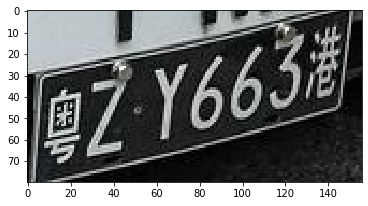

In [7]:
import base64
import io
from io import BytesIO
import json

# Quick test with cropped license plate images with Chinese characters
file = 'cropped-images/licenses/030-0.jpg'
with open(file, 'rb') as image:
    stream = io.BytesIO(image.read())
    image = Image.open(stream)
    imgplot = plt.imshow(image)

buffered = BytesIO()
image.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

response = json.loads(predictor.predict(img_str))
print('Detected Text: ', response[0][1][0])
print('Confidence: ', response[0][1][1])


Detected Text:  粤Z·888A港
Confidence:  0.9186562299728394


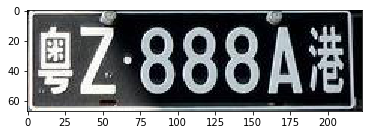

In [8]:
# Another quick test with cropped license plate images with Chinese characters
file = 'cropped-images/licenses/029-0.jpg'
with open(file, 'rb') as image:
    stream = io.BytesIO(image.read())
    image = Image.open(stream)
    imgplot = plt.imshow(image)

buffered = BytesIO()
image.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

response = json.loads(predictor.predict(img_str))
print('Detected Text: ', response[0][1][0])
print('Confidence: ', response[0][1][1])